In [1]:
%%capture
!rm -rf data/*
!unzip data.zip -d data/
!pip install --no-cache-dir pyldavis
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import pickle
%matplotlib inline

# Topic Modeling in Python

In Lisa Rhody's article, "Topic Modeling and Figurative Language", she uses LDA topic modeling to look at ekphrasis poetry. She argues that ekphrasis poetry is particulary well-suited to an LDA analysis because of the assumption of a previously existing set of topics. She's able to extract a number of topics, each constituted of a set of words and probabilities. While we don't have Rhody's corpus, we can use this technique on any large text corpus. We'll use a corpus of novels curated by Andrew Piper.

---

## Corpus Description
We'll look at an English-language subset of Andrew Piper's novel corpus, totaling 150 novels by British and American authors spanning the years 1771-1930. These texts are each in a separate plaintext file in our `data` folder. Metadata is contained in a spreadsheet distributed with the novel files by the [txtLAB](https://txtlab.org/) at McGill.

The metadata provided describes the corpus that exists as `.txt` files. So let's first read in the metadata:

In [2]:
metadata_tb = Table.read_table('data/txtlab_Novel150_English.csv')
metadata_tb.show(5)

filename,id,language,date,author,title,gender,person,length
"EN_1771_Mackenzie,Henry_TheManofFeeling_Novel.txt",151,English,1771,"Mackenzie,Henry",TheManofFeeling,male,first,36458
"EN_1771_Smollett,Tobias_TheExpedictionofHenryClinker_Nov ...",152,English,1771,"Smollett,Tobias",TheExpedictionofHenryClinker,male,first,148261
"EN_1778_Burney,Fanny_Evelina_Novel.txt",153,English,1778,"Burney,Fanny",Evelina,female,first,154168
"EN_1782_Burney,Fanny_Cecilia_Novel.txt",154,English,1782,"Burney,Fanny",Cecilia,female,third,328981
"EN_1786_Beckford,William_Vathek_Novel.txt",155,English,1786,"Beckford,William",Vathek,male,third,36077


Before we go anywhere, let's randomly shuffle the rows so that we don't have them ordered by dates or anything else:

In [3]:
np.random.seed(0)
metadata_tb = Table.from_df(metadata_tb.to_df().sample(frac=1))
metadata_tb.show(5)

filename,id,language,date,author,title,gender,person,length
"EN_1900_Dreiser,Theodore_SisterCarrie_Novel.txt",265,English,1900,"Dreiser,Theodore",SisterCarrie,male,third,156048
"EN_1853_Stowe,HarrietBeecher_UncleTom'sCabin_Novel.txt",213,English,1853,"Stowe,HarrietBeecher",UncleTom'sCabin,female,third,180498
"EN_1820_Scott,Walter_Ivanhoe_Novel.txt",184,English,1820,"Scott,Walter",Ivanhoe,male,third,175069
"EN_1895_Crane,Stephen_TheRedBadgeofCourage_Novel.txt",258,English,1895,"Crane,Stephen",TheRedBadgeofCourage,male,third,46049
"EN_1794_Godwin,William_CalebWilliams_Novel.txt",158,English,1794,"Godwin,William",CalebWilliams,male,first,143832


We can see the column variables we have in the metadata with the `.labels` attribute:

In [4]:
metadata_tb.labels

('filename',
 'id',
 'language',
 'date',
 'author',
 'title',
 'gender',
 'person',
 'length')

To clarify:
<ol><li>`filename`: Name of file on disk</li>
<li>`id`: Unique ID in Piper corpus</li>
<li>`language`: Language of novel</li>
<li>`date`: Initial publication date</li>
<li>`author`: Author's name </li>
<li>`title`: Title of novel</li>
<li>`gender`: Authorial gender</li>
<li>`person`: Textual perspective</li>
<li>`length`: Number of tokens in novel</li></ol>

We see a list of `filename`s in the table, these map into a folder we have called `txtlab_Novel150_English`:

In [5]:
!ls data/txtlab_Novel150_English/

EN_1771_Mackenzie,Henry_TheManofFeeling_Novel.txt
EN_1771_Smollett,Tobias_TheExpedictionofHenryClinker_Novel.txt
EN_1778_Burney,Fanny_Evelina_Novel.txt
EN_1782_Burney,Fanny_Cecilia_Novel.txt
EN_1786_Beckford,William_Vathek_Novel.txt
EN_1788_Wollstonecraft,Mary_Mary_Novel.txt
EN_1790_Radcliffe,Ann_ASicilianRomance_Novel.txt
EN_1794_Godwin,William_CalebWilliams_Novel.txt
EN_1794_Radcliffe,Ann_TheMysteriesofUdolpho_Novel.txt
EN_1794_Rowson,Susanna_CharlotteTemple_Novel.txt
EN_1795_Lewis,Matthew_TheMonk_Novel.txt
EN_1796_Bonhote,Elizabeth_BungayCastle_Novel.txt
EN_1796_Burney,Fanny_Camilla_Novel.txt
EN_1796_Hays,Mary_EmmaCourtney_Novel.txt
EN_1797_Foster,HannahWebster_TheCoquette_Novel.txt
EN_1798_Brown,CharlesBrockden_Wieland_Novel.txt
EN_1798_Wollstonecraft,Mary_Maria_Novel.txt
EN_1799_Brown,CharlesBrockden_ArthurMervyn_Novel.txt
EN_1800_Edgeworth,Maria_CastleRackrent_Novel.txt
EN_1801_Edgeworth,Maria_Belinda_Novel.txt
EN_1804_Opie,Amelia_AdelineMowbray_Novel.txt
EN_1805_Lewis,Matthew_Th

We can then read in the full text for each novel by iterating through the column, reading each file and appending the string to our `novel_list`:

In [5]:
# create empty list, entries will be list of tokens from each novel
novel_list = []

# iterate through filenames in metadata table
for filename in metadata_tb['filename']:
    
    # read in novel text as single string
    with open('data/txtlab_Novel150_English/'+filename, 'r') as f:
        novel = f.read()
    
    # clean up (no titles)
    toks = novel.split()  # split to tokens
    toks = [t for t in toks if not t.istitle() and not t.isupper()]  # quick & dirty no titles/proper nouns
    novel = ' '.join(toks)  # join to single string
    
    # add string
    novel_list.append(novel)

Let's double check they all came through:

In [6]:
len(novel_list)

150

And look at the first 200 characters of the fourth novel:

In [7]:
metadata_tb['author'][3], metadata_tb['title'][3], novel_list[3][:200]

('Crane,Stephen',
 'TheRedBadgeofCourage',
 '1 cold passed reluctantly from the earth, and the retiring fogs revealed an army stretched out on the hills, resting. the landscape changed from brown to green, the army awakened, and began to tremble')

---

## Document Term Matrix

Now we need to make a document term matrix, just as we have in the past two classes. We can pull in our `CountVectorizer` from `sklearn` again to create our dtm: 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

While you may not have seen the importance of `max_features`, `max_df` and `min_df` before, for topic modeling this is extremely important, because otherwise your topics will not be super coherent.

Let's start out with this:

- `max_features` = 5000  (i.e. only include 5000 tokens in our dtm)
- `max_df` = .8  (i.e. don't keep any tokens that appear in > 80% of the documents)
- `min_df` = 5  (i.e. only keep the token if it appears in > 5 documents)

We'll add in a `stop_words='english'` too, which automatically uses its own stopwords list to remove from our dtm:

In [9]:
cv = CountVectorizer(max_features=5000, stop_words='english', max_df=0.80, min_df=5)

As with most machine learning approaches, to validate your model you need training and testing partitions. Since we don't have any labels (topic modeling is *unsupervised* machine learning), we just need to do this for the novel strings:

In [10]:
train = novel_list[:120]
test = novel_list[120:]

Now we can use our `cv` to `fit_transform` our training list of novels (strings!):

In [11]:
dtm = cv.fit_transform(train)

To get our words back out we'll use the method `get_feature_names()`

In [12]:
dtm_feature_names = cv.get_feature_names()
dtm_feature_names[:10]

['abandon',
 'abandoned',
 'abbey',
 'abhorrence',
 'abide',
 'abilities',
 'ability',
 'abode',
 'abominable',
 'abrupt']

We can double check that our feature limit was enforced by calling `len` on the `dtm_feature_names`:

In [13]:
len(dtm_feature_names)

5000

We can throw our dtm into a `Table` like we have before too:

In [14]:
dtm_tb = Table(dtm_feature_names).with_rows(dtm.toarray())
dtm_tb.show(5)

---

## Topic Modeling

### [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) Models
LDA reflects an intuition that words in a text are not merely chosen at random but are drawn from underlying concepts (the so-called "latent variables"). The goal of LDA is to look across many texts in order to reverse engineer these concepts by finding words that tend to cluster with one another. For this reason, LDA has been referred to as "the mother of all word collocation techniques."

`sklearn` has the `LatentDirichletAllocation` function:

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

Let's check the doc string:

In [16]:
LatentDirichletAllocation?

Importantly, we'll note:
<li>`n_components`: This is the number of topics. Choosing this is the art of Topic Modeling </li>
<li>`max_iter`: TM initially uses random distribution, and iteratively tweaks model </li>

Let's just say we'll look for 10 topics. We'll do a `max_iter` of 5. Generally, the higher `max_iter` volume the better opportunity to the model has to accurately tune, but it also takes much longer.

In [17]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5)

Before we `fit` the model, we need to remember that with a lot of these probabilistic models random number generators are used to star the algorithm. If we want our results to be reproducible, we need to set the random seed of the math library we use, in this case `numpy`:

In [18]:
np.random.seed(0)

Now we just `fit` the model, as we've done with all `sklearn` models! This may take a while, a lot is going on:

In [19]:
lda_model = lda.fit(dtm)

/srv/app/venv/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


### Evaluation

One measure of the model's fit is [perplexity](https://en.wikipedia.org/wiki/Perplexity#Perplexity_of_a_probability_model), with which we can judge how well the model fits the data. We need to call this on our `test` portion after it's been transformed into a dtm:

In [20]:
lda_model.perplexity(cv.transform(test))

5201.6432940072091

***NOTE***: Currently `sklearn`s perplexity algorithm is [broken](https://github.com/scikit-learn/scikit-learn/issues/6777).

The lower the perplexity, the better the fit of the model. So one way to get the optimal number of topics would be to loop through several numbers of topics and minimize the perplexity value.

Unfortunately, it has been shown time and again that minimizing perplexity does not actually separate topics into coherent groups that humans would.

### Choosing the best model

Since traditional metrics of evaluating a model's accuracy have not proven to conform to human understanding, a new appraoch was developed by [David Minmo in 2011](http://dirichlet.net/pdf/mimno11optimizing.pdf).

> this score measures how much, within the words used to describe a topic, a common word is in average a good predictor for a less common word. ([More on topic coherency](http://qpleple.com/topic-coherence-to-evaluate-topic-models/).)

Here we look for the highest value. This algorithm has only been implemented in the Python `gensim` library. I ran the following code for you on a remote server because it takes a while!

---

```python
import pickle
from joblib import Parallel, delayed
import multiprocessing


def try_topic_number(i):
    lda_model = gensim.models.LdaModel(
        corpus,
        num_topics=i,
        id2word=dictionary,
        iterations=1000,
        alpha='auto',
        passes=4)

    cm = gensim.models.CoherenceModel(
        model=lda_model,
        corpus=corpus,
        dictionary=dictionary,
        coherence='u_mass')

    return cm.get_coherence()


if __name__ == '__main__':

    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(delayed(try_topic_number)(i)
                                         for i in try_topic_n)

    pickle.dump(results, open('scores.pkl', 'wb'))
```

---

You can see above I've dumped the coherence scores into a binary `pickle` file. A `pickle` is simply any Python object that has been saved to a binary file. We can `load` these in too:

In [21]:
try_topic_n = list(range(5,200,2))
scores = pickle.load(open('scripts/scores.pkl', 'rb'))
list(zip(try_topic_n, scores))

[(5, -1.0719929991318369),
 (7, -0.96332378833297394),
 (9, -1.0370206116730427),
 (11, -0.9391420508605669),
 (13, -0.89941919629993672),
 (15, -0.97948998912659335),
 (17, -0.91916766531351723),
 (19, -0.90498737828676379),
 (21, -0.94107971748945507),
 (23, -0.91727178335847159),
 (25, -0.94560202854227282),
 (27, -0.94721997500437649),
 (29, -0.93943916769500091),
 (31, -0.94078558004436297),
 (33, -0.95568210386623209),
 (35, -0.97168223052159419),
 (37, -0.95621895351631225),
 (39, -0.96524311591964762),
 (41, -0.94611608471546926),
 (43, -0.94697199863616643),
 (45, -0.93911588662731871),
 (47, -0.9498111580639399),
 (49, -0.95470584233581701),
 (51, -0.94337074894135131),
 (53, -0.95659529167559731),
 (55, -0.95964640866303286),
 (57, -0.95353739781735525),
 (59, -0.96554670690867095),
 (61, -0.96413249399173662),
 (63, -0.9597071349712456),
 (65, -0.95322075064367251),
 (67, -0.97453921826460621),
 (69, -0.95904498451803188),
 (71, -0.95284091993987274),
 (73, -0.9467063411643

Let's plot these results:

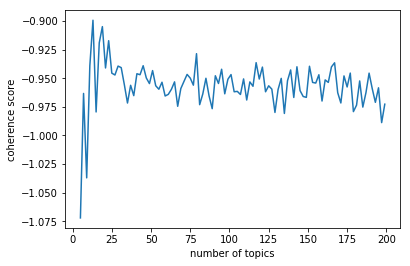

In [27]:
plt.plot(try_topic_n, [x for x in scores])
plt.xlabel('number of topics')
plt.ylabel('coherence score')

`numpy` has a handy `argmax` or `argmin` function that returns the index of the highest or lowest value in an array:

In [23]:
np.argmax(scores)

4

Then we can just index our topic numbers to get the corresponding number of topics with the highest coherency:

In [24]:
try_topic_n[np.argmax(scores)]

13

I've retrained the model for 13 topics and exported as below (note the `max_iter=1000` takes a long time, so I've pickled the model again):

---

```python
lda = LatentDirichletAllocation(n_components=13, max_iter=1000)
lda_model = lda.fit(dtm)

pickle.dump((lda, lda_model, dtm, cv), open('13-topics.pkl', 'wb'))
```

---

We can load in the pre-trained model from the `pickle`:

In [25]:
lda, lda_model, dtm, cv = pickle.load(open('scripts/13-topics.pkl', 'rb'))

Many papers in the social sciences still don't use a quantitative evaluation metric. Many use the library `pyLDAvis` to simply visualize the topic distributions, looking for the right size and little overlap in topics as markers of a well-chosen number of topics:

In [38]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, dtm, cv)

Process ForkPoolWorker-17:
Traceback (most recent call last):
Process ForkPoolWorker-18:
Process ForkPoolWorker-15:
Process ForkPoolWorker-12:
Process ForkPoolWorker-16:
Process ForkPoolWorker-13:
Process ForkPoolWorker-11:
Process ForkPoolWorker-14:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessin

KeyboardInterrupt: 

### Topics

To `print` the topics, we can write a function. `display_topics` will print the most probable words to show up in each topic.

In [28]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(topic_idx, " ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

Now let's print the top 10 words of the 20 topics for the model we trained, using our `display_topics` function. Have a look through the output and see what topics you can spot:

In [29]:
display_topics(lda, dtm_feature_names, 10)

0 aunt mamma cousin sisters tea papa uncle widow pounds everybody
1 ve didn ain em wouldn ye dogs kitchen wheat couldn
2 maiden gods philosopher rejoined divine apartment statue marble inquired thy
3 ye honour king nation army squire government friar lad baron
4 ve honour didn tea aunt thee thou cousin thy ye
5 honour madam uncle ma wholly favour extremely begged behaviour coach
6 thy religion persons anguish apartment beheld principles passions sentiment respecting
7 castle woods mountains scout apartment chateau ma marquis concerning aunt
8 ve tea lad squire th margaret yo grey colour baby
9 ship boat captain doctor deck shore sail whilst vessel island
10 thou thee thy ye hath hast holy minister knight thine
11 laura neighbourhood doctor clerk interview interests boat evidence honour inquired
12 ve didn isn wouldn doesn couldn social haven dollars wasn


We can `print` which topic each novel is closest to by indexing the topic probabilities and using the `argmax` function:

In [30]:
doc_topic = lda.transform(dtm)

for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    print(metadata_tb['author'][n], metadata_tb['title'][n])
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

Dreiser,Theodore SisterCarrie
doc: 0 topic: 12

Stowe,HarrietBeecher UncleTom'sCabin
doc: 1 topic: 1

Scott,Walter Ivanhoe
doc: 2 topic: 10

Crane,Stephen TheRedBadgeofCourage
doc: 3 topic: 1

Godwin,William CalebWilliams
doc: 4 topic: 6

Hardy,Thomas TessoftheD'Urbervilles
doc: 5 topic: 8

Child,Lydia Philothea
doc: 6 topic: 2

Braddon,Mary TheGoldenCalf
doc: 7 topic: 0

Alcott,Louisa LittleWomen
doc: 8 topic: 0

Dickens,Charles GreatExpectations
doc: 9 topic: 1

Lawrence,D.H. SonsandLovers
doc: 10 topic: 1

Bronte,Ann TheTenantofWildfellHall
doc: 11 topic: 0

Eliot,George Romola
doc: 12 topic: 10

Aguilar,Grace ValeofCedars
doc: 13 topic: 10

Yonge,Charlotte TheHeirofRedcliffe
doc: 14 topic: 0

Cooper,JamesFenimore ThePioneers
doc: 15 topic: 3

Trollope,Anthony PhineasFinn
doc: 16 topic: 0

Stevenson,RobertLouis JekyllandHyde
doc: 17 topic: 9

Borrow,George TheBibleinSpain
doc: 18 topic: 3

Wollstonecraft,Mary Maria
doc: 19 topic: 6

Norris,Frank ThePit
doc: 20 topic: 1

Craik,Dinah 

To get the probabilities for each topic for a given book we can print the whole probability list for a given novel:

In [31]:
metadata_tb['author'][25], metadata_tb['title'][25], doc_topic[25]

('Edgeworth,Maria',
 'Leonora',
 array([  1.63855409e-01,   1.19987718e-05,   7.96414969e-03,
          1.14255336e-02,   1.19986082e-05,   3.95844424e-01,
          3.90338234e-01,   1.26144617e-02,   1.19988124e-05,
          1.19988548e-05,   1.36693857e-02,   1.19988142e-05,
          4.22840900e-03]))

### Challenge

Add these topic assignments back to our `Table` `metadata_tb`

In [32]:
# YOUR CODE HERE

## Interpreting the Model

There are many strategies that can be used to interpret the output of a topic model. In this case, we will look for any correlations between the topic distributions and metadata.

We'll first grab all the topic distributions similar to what we did above. Remember, the order of the novels is still the same!

In [33]:
list_of_doctopics = [doc_topic[n] for n in range(len(doc_topic))]
list_of_doctopics[0]

array([  3.74263196e-03,   2.41587636e-01,   5.86537101e-06,
         5.86538222e-06,   5.86527464e-06,   3.66496255e-02,
         2.68368745e-02,   5.86538173e-06,   5.86538193e-06,
         5.86538412e-06,   8.79970468e-04,   5.86538090e-06,
         6.90262204e-01])

We'll make a `DataFrame`, which is similar to a `Table`, with the probabilities for the topics (columns) and documents (rows):

In [34]:
df = pd.DataFrame(list_of_doctopics)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.003743,0.241588,0.000006,0.000006,0.000006,0.036650,0.026837,0.000006,0.000006,0.000006,0.000880,0.000006,0.690262
1,0.161628,0.530295,0.000004,0.029890,0.000004,0.000004,0.103822,0.000004,0.026528,0.004156,0.130962,0.000004,0.012698
2,0.000003,0.000003,0.000003,0.181354,0.000003,0.035976,0.031576,0.061129,0.000003,0.000003,0.689937,0.000003,0.000003
3,0.000014,0.719892,0.000014,0.021756,0.000014,0.000014,0.052180,0.152988,0.049613,0.000014,0.000014,0.000014,0.003472
4,0.000005,0.000005,0.000005,0.104593,0.000005,0.167195,0.726078,0.000005,0.000005,0.002090,0.000005,0.000005,0.000005


We can add these columns to our `metadata_tb` `Table`:

In [35]:
meta = metadata_tb.to_df()
meta[df.columns] = df
meta.head()

,filename,id,language,date,author,title,gender,person,length,0,...,3,4,5,6,7,8,9,10,11,12
0,"EN_1900_Dreiser,Theodore_SisterCarrie_Novel.txt",265,English,1900,"Dreiser,Theodore",SisterCarrie,male,third,156048,0.003743,...,0.000006,0.000006,0.036650,0.026837,0.000006,0.000006,0.000006,0.000880,0.000006,0.690262
1,"EN_1853_Stowe,HarrietBeecher_UncleTom'sCabin_N...",213,English,1853,"Stowe,HarrietBeecher",UncleTom'sCabin,female,third,180498,0.161628,...,0.029890,0.000004,0.000004,0.103822,0.000004,0.026528,0.004156,0.130962,0.000004,0.012698
2,"EN_1820_Scott,Walter_Ivanhoe_Novel.txt",184,English,1820,"Scott,Walter",Ivanhoe,male,third,175069,0.000003,...,0.181354,0.000003,0.035976,0.031576,0.061129,0.000003,0.000003,0.689937,0.000003,0.000003
3,"EN_1895_Crane,Stephen_TheRedBadgeofCourage_Nov...",258,English,1895,"Crane,Stephen",TheRedBadgeofCourage,male,third,46049,0.000014,...,0.021756,0.000014,0.000014,0.052180,0.152988,0.049613,0.000014,0.000014,0.000014,0.003472
4,"EN_1794_Godwin,William_CalebWilliams_Novel.txt",158,English,1794,"Godwin,William",CalebWilliams,male,first,143832,0.000005,...,0.104593,0.000005,0.167195,0.726078,0.000005,0.000005,0.002090,0.000005,0.000005,0.000005


The `corr()` method will give us a correlation matrix:

In [36]:
meta.corr()

,id,date,length,0,1,2,3,4,5,6,7,8,9,10,11,12
id,1.000000,0.989293,-0.160204,-0.152434,0.572221,-0.078462,-0.291158,0.177250,-0.508749,-0.516003,-0.302783,0.283322,0.182507,-0.108731,0.009553,0.546103
date,0.989293,1.000000,-0.131386,-0.109032,0.538569,-0.060252,-0.304192,0.155241,-0.555964,-0.532168,-0.309598,0.308496,0.205571,-0.081166,0.039784,0.536713
length,-0.160204,-0.131386,1.000000,0.263755,-0.244553,-0.062703,-0.042924,-0.743355,0.275029,-0.164554,0.018215,0.062639,-0.207433,-0.009373,0.144859,0.021067
0,-0.152434,-0.109032,0.263755,1.000000,-0.181405,-0.057494,-0.068135,-0.131120,0.053067,-0.132030,-0.188447,-0.035257,-0.189187,-0.135976,-0.050185,-0.134841
1,0.572221,0.538569,-0.244553,-0.181405,1.000000,-0.068212,-0.180374,0.329774,-0.259983,-0.295489,-0.133439,-0.052223,-0.018205,-0.153772,-0.122199,-0.025223
2,-0.078462,-0.060252,-0.062703,-0.057494,-0.068212,1.000000,-0.039680,-0.025743,-0.043849,-0.048615,-0.034832,-0.066170,-0.038329,-0.033162,-0.013116,-0.064700
3,-0.291158,-0.304192,-0.042924,-0.068135,-0.180374,-0.039680,1.000000,0.047297,-0.036884,-0.078284,0.068400,-0.165410,-0.047984,0.035017,-0.061852,-0.171921
4,0.177250,0.155241,-0.743355,-0.131120,0.329774,-0.025743,0.047297,1.000000,-0.168267,-0.008754,-0.075140,-0.047680,0.170442,-0.104526,-0.079231,-0.027975
5,-0.508749,-0.555964,0.275029,0.053067,-0.259983,-0.043849,-0.036884,-0.168267,1.000000,0.108961,-0.028937,-0.199106,-0.151135,-0.130868,-0.103558,-0.211949
6,-0.516003,-0.532168,-0.164554,-0.132030,-0.295489,-0.048615,-0.078284,-0.008754,0.108961,1.000000,0.051374,-0.223339,-0.108129,-0.034809,-0.058271,-0.243017


We see some strong correlations of topics with `date`, recall:

In [37]:
display_topics(lda, dtm_feature_names, 10)

0 aunt mamma cousin sisters tea papa uncle widow pounds everybody
1 ve didn ain em wouldn ye dogs kitchen wheat couldn
2 maiden gods philosopher rejoined divine apartment statue marble inquired thy
3 ye honour king nation army squire government friar lad baron
4 ve honour didn tea aunt thee thou cousin thy ye
5 honour madam uncle ma wholly favour extremely begged behaviour coach
6 thy religion persons anguish apartment beheld principles passions sentiment respecting
7 castle woods mountains scout apartment chateau ma marquis concerning aunt
8 ve tea lad squire th margaret yo grey colour baby
9 ship boat captain doctor deck shore sail whilst vessel island
10 thou thee thy ye hath hast holy minister knight thine
11 laura neighbourhood doctor clerk interview interests boat evidence honour inquired
12 ve didn isn wouldn doesn couldn social haven dollars wasn


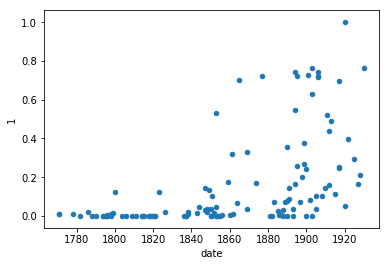

In [38]:
meta.plot.scatter(x='date', y=1)

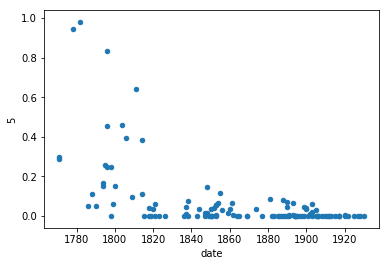

In [39]:
meta.plot.scatter(x='date', y=5)

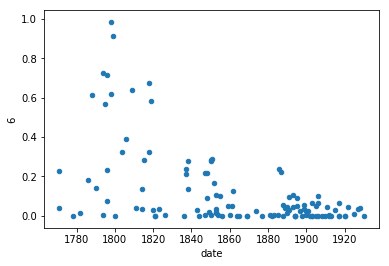

In [40]:
meta.plot.scatter(x='date', y=6)

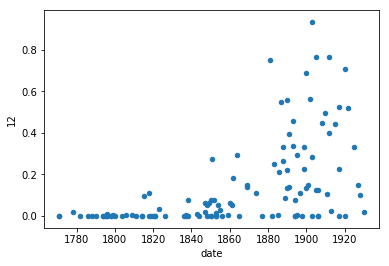

In [41]:
meta.plot.scatter(x='date', y=12)

Why do you think we see this?

# Homework

We're going to download the [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/), a widely used corpus for demos of general texts:

> The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of my knowledge, it was originally collected by Ken Lang, probably for his Newsweeder: Learning to filter netnews paper, though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

Let's read in the training data:

In [2]:
train_subset = pickle.load(open('scripts/20-news-train.pkl', 'rb'))

Here are the predetermined catgories:

In [3]:
train_subset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Since we're topic modeling, we don't care about what they've been labeled, but it'll be interesting to see how our topics line up with these!

How many documents are there?

In [4]:
len(train_subset.data)

11314

Let's get a list of documents as strings just like we did with the novels, and then we'll randomly shuffle them in case they're ordered by category already:

In [5]:
documents_train = train_subset.data
np.random.shuffle(documents_train)

In [6]:
print(documents_train[0])

From: ritley@uimrl7.mrl.uiuc.edu ()
Subject: SEEKING THERMOCOUPLE AMPLIFIER CIRCUIT
Reply-To: ritley@uiucmrl.bitnet ()
Organization: Materials Research Lab
Lines: 17



I would like to be able to amplify a voltage signal which is
output from a thermocouple, preferably by a factor of
100 or 1000 ---- so that the resulting voltage can be fed
more easily into a personal-computer-based ADC data
acquisition card.

Might anyone be able to point me to references to such
circuits?  I have seen simple amplifier circuits before, but
I am not sure how well they work in practice.

In this case, I'd like something which will amplify sufficiently
"nicely" to be used for thermocouples (say, a few degrees
accuracy or better).

Any pointers would be greatly appreciated!



Now we'll do the same for the test set:

In [7]:
test_subset = pickle.load(open('scripts/20-news-test.pkl', 'rb'))
documents_test = test_subset.data
np.random.shuffle(documents_test)
print(documents_test[0])

From: michaelq@tlaloc.sw.stratus.com (Michael Quicquaro)
Subject: FOR SALE:  1990 Pontiac Grand Prix SE
Organization: Stratus Computer, Software Engineering
Lines: 48
Distribution: usa
NNTP-Posting-Host: tlaloc.sw.stratus.com

FOR SALE:  1990 Pontiac Grand Prix SE

2-Door Coupe,
White, White rims, Gray interior.
58K miles (mostly highway),
3.1 Litre V6 multi-port fuel-injected engine,
5 speed manual transmission.

One owner.

Options include:

A/C,
Rear defogger,
Power steering,
Power brakes,
Power windows,
Power locks,
Power mirrors,
Cruise control,
Power glass moonroof with sunshade,
Power seat/recliner (driver's),
Power seat/comfort/lumbar/headrest (both front seats),
Trunk pass-through (for skis)
AM/FM cassette stero (6 speakers),
Electronic monitor/service system with graphic compass,
Stereo controls duplicated on steering wheel,
Remote-keyless entry,
and others.

Asking $11,500.

The car looks and rides like it just rolled off
of the dealers lot.  It has been garaged and pampered

## TASK:

You now have two arrays of strings: `documents_train` and `documents_test`. Create a `dtm` and then a topic model for `k` number of topics. Just choose one number of `k` and a very low `iter` value for the training so it doesn't take too long. 

See how the topics match up to the annotated categories, and play with different ways of preprocessing the data. Use the `pyLDAvis` library to evaluate your model.

What did you have to do to get decent results?

In [17]:
cv2 = CountVectorizer(max_features=5000, stop_words='english', max_df=0.80, min_df=5)
dtm2 = cv2.fit_transform(documents_train)
#dtm2_feature_names = cv2.get_feature_names()
#dtm_tb2 = Table(dtm2_feature_names).with_rows(dtm2.toarray())
#dtm_tb.show(5)
lda2 = LatentDirichletAllocation(n_components=5, max_iter=2)
np.random.seed(0)
lda2_model = lda2.fit(dtm2)

/srv/app/venv/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [19]:
pickle.dump((lda2, lda2_model, dtm2, cv2), open('7-topics.pkl', 'wb'))
lda2, lda2_model, dtm2, cv2 = pickle.load(open('7-topics.pkl', 'rb'))
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda2_model, dtm2, cv2)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      30.034926        1       1 -0.134465 -0.015341
0      28.302467        1       2 -0.153047  0.053781
1      21.902273        1       3 -0.144073  0.183001
3      12.007741        1       4 -0.060235 -0.256212
2       7.752593        1       5  0.491821  0.034770, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
607   Default  67649.000000          ax  67649.000000  30.0000  30.0000
2838  Default   5063.000000         max   5063.000000  29.0000  29.0000
848   Default   3878.000000          ca   3878.000000  28.0000  28.0000
3340  Default   5844.000000      people   5844.000000  27.0000  27.0000
1946  Default   1437.000000         g9v   1437.000000  26.0000  26.0000
2019  Default   3122.000000         god   3122.000000  25.0000  25.0000
1591  Default  21826.000000         edu  21826.000000  24.0000  24.0000
619   Default   1111.000000         b8f   1111.000000  23.0000  23.0000
0     Default   1431.000000          00   1431.000000  22.0000  22.0000
2034  Default   1796.000000  government   1796.000000  21.0000  21.0000
1826  Default   2326.000000        file   2326.000000  20.0000  20.0000
288   Default    942.000000         a86    942.000000  19.0000  19.0000
3397  Default    925.000000          pl    925.000000  18.0000  18.0000
18    Default   2252.000000          10   2252.000000  17.0000  17.0000
1076  Default  12381.000000         com  12381.000000  16.0000  16.0000
4888  Default   1862.000000     windows   1862.000000  15.0000  15.0000
4887  Default   1114.000000      window   1114.000000  14.0000  14.0000
4442  Default   1180.000000        team   1180.000000  13.0000  13.0000
91    Default    784.000000         1d9    784.000000  12.0000  12.0000
4944  Default   7889.000000      writes   7889.000000  11.0000  11.0000
1952  Default   1201.000000        game   1201.000000  10.0000  10.0000
2602  Default   1688.000000         law   1688.000000   9.0000   9.0000
152   Default    698.000000         34u    698.000000   8.0000   8.0000
46    Default    727.000000         145    727.000000   7.0000   7.0000
49    Default   1720.000000          15   1720.000000   6.0000   6.0000
4199  Default   1822.000000       space   1822.000000   5.0000   5.0000
2473  Default   1385.000000       jesus   1385.000000   4.0000   4.0000
2230  Default   4975.000000        host   4975.000000   3.0000   3.0000
2238  Default   1082.000000          hp   1082.000000   2.0000   2.0000
28    Default   1307.000000          11   1307.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
91     Topic5    783.398585         1d9    784.233851   2.5561  -4.9367
152    Topic5    698.146677         34u    698.973965   2.5560  -5.0519
17     Topic5    543.309197          0t    544.125726   2.5556  -5.3026
165    Topic5    502.217659          3t    503.039939   2.5555  -5.3813
235    Topic5    498.623191         75u    499.442651   2.5555  -5.3885
98     Topic5    485.865014          1t    486.689133   2.5554  -5.4144
2003   Topic5    448.162906         giz    448.982251   2.5553  -5.4952
704    Topic5    414.222403         bhj    415.039576   2.5552  -5.5739
138    Topic5    407.176767         2tm    407.996808   2.5551  -5.5911
131    Topic5    386.326104         2di    387.147708   2.5550  -5.6436
1306   Topic5    353.321883          cx    354.191054   2.5547  -5.7329
241    Topic5    320.070076         7ey    320.885275   2.5546  -5.8318
999    Topic5    309.912707         chz    310.725024   2.5545  -5.8640
12     Topic5    309.554748          0d    310.373870   2.5545  -5.8652
218    Topic5    298.553629         6ei    299.368045   2.5544  -5.9014
840    Topic5    250.341879         bxn    251.156530   2.5539  -6.0775
1313   Topic5    231.317723          d9    232.1306

In [20]:
lda2_model.perplexity(cv.transform(documents_test))

2166.7165739879611

I had to decrease the number of topics from 7 to 5, because when I had 7 topics, there were many overlapping circles. Thus, when there are 5 topics, there aren't as many repeated words in between the topics.

In [44]:
#try_topic_n = list(range(5,200,2))
#pickle.dump((lda, lda_model, dtm, cv), open('13-topics.pkl', 'wb'))

#scores2 = pickle.load(open('7-topics.pkl', 'rb'))
#list(zip(try_topic_n, scores2))

[(5, LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
               evaluate_every=-1, learning_decay=0.7, learning_method=None,
               learning_offset=10.0, max_doc_update_iter=100, max_iter=2,
               mean_change_tol=0.001, n_components=7, n_jobs=1,
               n_topics=None, perp_tol=0.1, random_state=None,
               topic_word_prior=None, total_samples=1000000.0, verbose=0)),
 (7, LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
               evaluate_every=-1, learning_decay=0.7, learning_method=None,
               learning_offset=10.0, max_doc_update_iter=100, max_iter=2,
               mean_change_tol=0.001, n_components=7, n_jobs=1,
               n_topics=None, perp_tol=0.1, random_state=None,
               topic_word_prior=None, total_samples=1000000.0, verbose=0)),
 (9, <11314x5000 sparse matrix of type '<class 'numpy.int64'>'
  	with 842020 stored elements in Compressed Sparse Row format>),
 (11, CountVectorizer(analy

# BONUS (not assigned)

Create a classifier from this corpus. They're assigned group are in the `target` attribute:

In [ ]:
train_subset.target

In [ ]:
test_subset.target